In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from simsimpy import *
import random

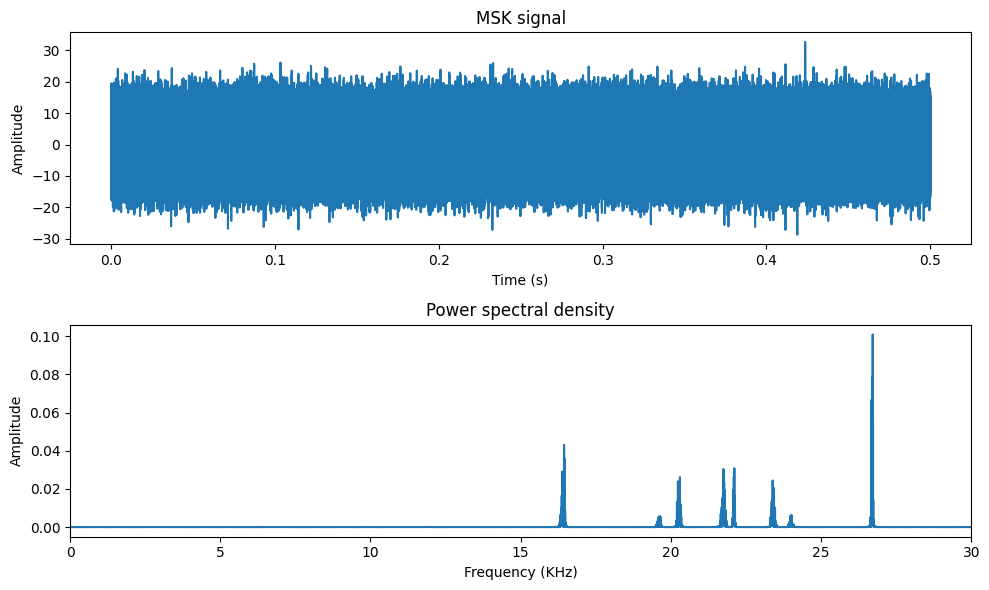

In [67]:
carriers = np.array([16.40e3, 19.60e3, 20.27e3, 21.75e3, 22.10e3, 23.40e3, 24.00e3, 26.70e3])
baudrate = np.array([200,     200,     200,     200,     100,     200,     200,     100])
T_symbols = 1/baudrate
fs = 4e6
time = 0.5

t = np.linspace(0, time, int(fs*time))

# Generate the signal
msk_data_single = np.zeros((len(carriers), len(t)))
msk_data = np.zeros_like(t)
offset = np.zeros_like(carriers)
phase_offset = np.zeros_like(carriers)
amplitude = np.zeros_like(carriers)
data_true = np.zeros((len(carriers),int(time/T_symbols[0])))
phase = np.zeros((len(carriers),len(t)))
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):    
    offset[i] = random.uniform(-T_symbols[i]/2, T_symbols[i]/2)
    phase_offset[i] = random.uniform(-np.pi, np.pi)
    amplitude[i] = random.uniform(0.5, 2)
    #amplitude[i] = 1
    msk_data_single[i], _, data_temp, phase[i] = generate_msk(int(time/T), 0.5, T, carrier, fs, offset=offset[i], phase_offset=phase_offset[i], amplitude=amplitude[i])
    msk_data += msk_data_single[i]
    data_true[i,0:int(time/T)] = data_temp[0:int(time/T)]
# Add noise
msk_data += np.random.normal(0, 5, msk_data.shape)

# calculate fft
f, fft_msk_data = signal.periodogram(msk_data, fs, nfft=len(msk_data))

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data)
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal')


axs[1].plot(f/1e3, fft_msk_data)#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (KHz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30)
plt.tight_layout()


# add zeros

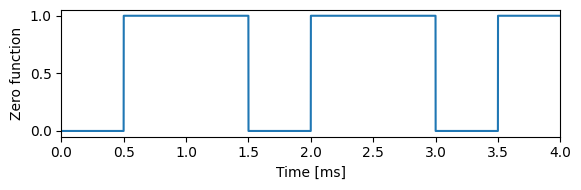

In [68]:
zeroes_test = np.ones_like(msk_data)
zeroes_test_inserted = add_zeros(zeroes_test, 0.0005, 0.0015, fs)

fig, axs = plt.subplots(figsize=(6, 2))
axs.plot(t/1e-3, zeroes_test_inserted)
axs.set_ylabel('Zero function')
axs.set_xlabel('Time [ms]')
axs.set_xlim(0, 4)

plt.tight_layout()
plt.savefig('figures/analysis/zero_function.pdf')


In [69]:
#msk_data_zeros = add_zeros(msk_data, 200e-6, 200e-6+10e-6, fs)
msk_data_zeros = add_zeros(msk_data, 0.0005, 0.0015, fs)

(0.0, 0.01)

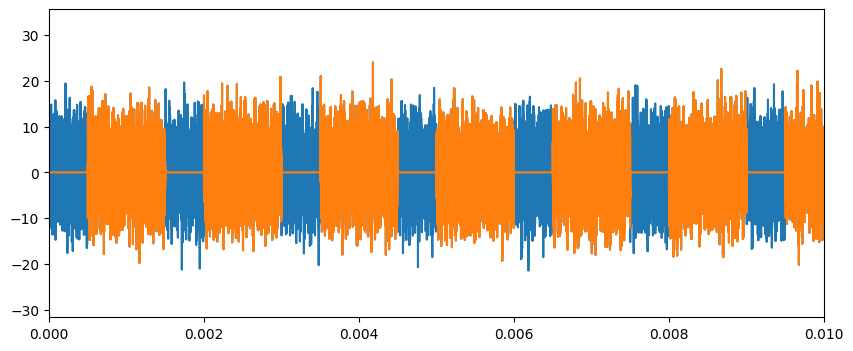

In [70]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(t,msk_data)


plt.plot(t,msk_data_zeros)
plt.xlim(0, 0.01)

c:\Users\claes\miniconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
c:\Users\claes\miniconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\claes\miniconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


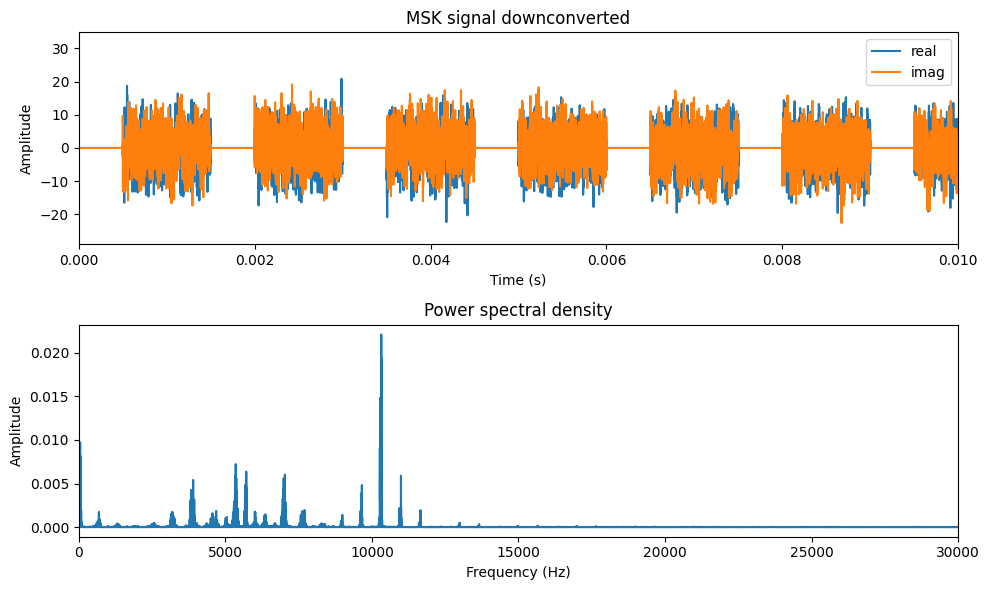

In [71]:

msk_data_down = np.zeros((len(carriers), len(t)), dtype=complex)
for i, (carrier, T) in enumerate(zip(carriers, T_symbols)):
    msk_data_down[i] = msk_data_zeros*np.exp(-1j*2*np.pi*carrier*t)


# calculate fft
fft_msk_data_down = np.zeros((len(carriers), len(t)), dtype=complex)
for i in range(len(carriers)):
    f, fft_msk_data_down[i] = signal.periodogram(msk_data_down[i], fs, nfft=len(msk_data_down[i]))


fig, axs = plt.subplots(2, 1, figsize=(10, 6))

index = 0
axs[0].plot(t, msk_data_down[index].real, label='real')
axs[0].plot(t, msk_data_down[index].imag, label='imag')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal downconverted')
axs[0].legend()
axs[0].set_xlim(0, 0.01)

axs[1].plot(f, fft_msk_data_down[index])#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30000)

plt.tight_layout()

C:\Users\claes\AppData\Local\Temp\ipykernel_18604\809111335.py:47: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\claes\miniconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\claes\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


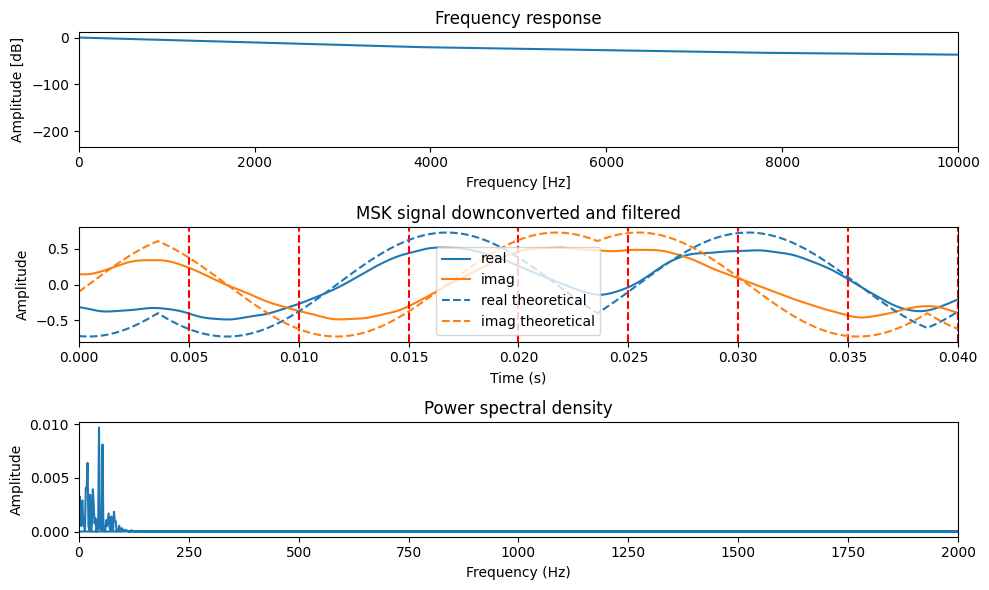

In [72]:
sos = signal.butter(2,0.0006, 'low', output='sos')
w, h = signal.sosfreqz(sos, fs=fs)

index = 0
msk_data_down_filtered = np.zeros_like(msk_data_down)
for i in range(len(carriers)):
    sos = signal.butter(2,1/T_symbols[i], 'low', output='sos', fs=fs) # 1/T_symbols[0]/2 might removes the noise, but also the signal 
    temp = np.append(np.ones(int(fs*T_symbols[i]))*np.mean(msk_data_down[i,0:int(fs*T_symbols[i])]), msk_data_down[i])
    #msk_data_down_filtered[i] = signal.sosfiltfilt(sos, msk_data_down[i])[int(fs*T_symbols[i]):]
    msk_data_down_filtered[i] = signal.sosfiltfilt(sos, temp)[int(fs*T_symbols[i]):]

fft_msk_data_down_filtered = np.zeros_like(fft_msk_data_down)
for i in range(len(carriers)):
    f, fft_msk_data_down_filtered[i] = signal.periodogram(msk_data_down_filtered[i], fs, nfft=len(msk_data_down_filtered[i]))
#f, fft_msk_data_down_filtered = signal.periodogram(msk_data_down_filtered, fs, nfft=len(msk_data_down_filtered))


fig, axs = plt.subplots(3, 1, figsize=(10, 6))

axs[0].plot(w, 20 * np.log10(np.abs(h)))
axs[0].set_ylabel('Amplitude [dB]')
axs[0].set_xlabel('Frequency [Hz]')
axs[0].set_title('Frequency response')
axs[0].set_xlim(0, 10e3)

axs[1].plot(t, msk_data_down_filtered[index].real, label='real')
axs[1].plot(t, msk_data_down_filtered[index].imag, label='imag')
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Time (s)')
axs[1].set_title('MSK signal downconverted and filtered')
# vertical line at every symbol
for i in range(1, int(time/T_symbols[index])):
    axs[1].axvline(x=i*T_symbols[index], color='r', linestyle='--')
#axs[1].set_ylim(-1.5, 1.5)
axs[1].plot(t, 1/2*amplitude[index]*np.cos(-2*np.pi*carriers[index]*offset[index] + phase[index] + phase_offset[index]), label='real theoretical', linestyle='--', color='C0')
#axs[1].plot(t, 1/2*np.cos(phase[index] + phase_offset[index]), label='reahgvl theoretical', linestyle='--', color='C4')
axs[1].plot(t, 1/2*amplitude[index]*np.sin(-2*np.pi*carriers[index]*offset[index] + phase[index] + phase_offset[index]), label='imag theoretical', linestyle='--',color='C1')
axs[1].set_xlim(0, 0.04)
axs[1].legend()

axs[2].plot(f, fft_msk_data_down_filtered[index])#10*np.log10(Pxx))
axs[2].set_ylabel('Amplitude')
axs[2].set_xlabel('Frequency (Hz)')
axs[2].set_title('Power spectral density')
axs[2].set_xlim(0, 2e3)

plt.tight_layout()

# parameter estimation

In [74]:
tau_hat = np.zeros_like(carriers)
theta_hat = np.zeros_like(carriers)

for i in range(len(carriers)):
    _, _, tau_hat[i], theta_hat[i] = phase_and_time_sync(msk_data_down_filtered[i], int(fs*T_symbols[i]),  T_symbols[i], fs,int(time/T))
    #theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*tau_hat[i]) % (np.pi) - 0.5*np.pi

    if tau_hat[i] < 0 :
        theta_hat[i] += 0.5*np.pi  # this is not correct but it gives good results
    
    
    theta_hat[i] = (theta_hat[i] + 2*np.pi*carriers[i]*tau_hat[i]) % (np.pi) - 0.5*np.pi

## amplitude estimation

In [75]:
a_hat = np.zeros(len(carriers))

for i in range(len(carriers)):
    a_hat[i] = amplitude_estimation(msk_data_down_filtered[i, int(1*fs*T_symbols[i]):-int(1*fs*T_symbols[i])])
    print(f'Amplitude {i}: {a_hat[i]}')
    a_hat[i] = 1

Amplitude 0: 0.9638195610032032
Amplitude 1: 0.5053832965362269
Amplitude 2: 0.8449612792342862
Amplitude 3: 1.000471327331381
Amplitude 4: 0.8045816293178985
Amplitude 5: 0.8951711949680983
Amplitude 6: 0.5036167944766178
Amplitude 7: 1.2325460869642972


# parameter correction

In [94]:
msk_corrected = np.zeros_like(msk_data_down_filtered)
for i in range(len(carriers)):
    msk_corrected[i] = np.roll(msk_data_down_filtered[i]*np.exp(1j*(theta_hat[i])),-int(tau_hat[i]*fs))

# decoder

In [95]:
decoded_bits = np.zeros((len(carriers), int(time/T_symbols[0])))
for i in range(len(carriers)):
    decoded_bits[i,0:int(time/T_symbols[i])], _ = viterbi_decoder(msk_corrected[i], int(T_symbols[i]*fs))[0:int(time/T_symbols[i])]


# performance evaluation

In [96]:
for i in range(len(carriers)):
    print(f'Carrier {i+1}:')
    print(f'Offset: {np.round(offset[i],6)} Offset estimated: {np.round(tau_hat[i],6)}')
    print(f'Phase offset: {np.round(phase_offset[i]/np.pi,4)} Phase offset estimated: {np.round(theta_hat[i]/np.pi,4)}')
    print(f'Amplitude: {np.round(amplitude[i],4)} Amplitude estimated: {np.round(a_hat[i],4)}')
    print(f'Error rate: {np.sum(decoded_bits[i] != data_true[i])/len(data_true[i])}')
    print(f'Number of errors: {np.sum(decoded_bits[i] != data_true[i])}')

Carrier 1:
Offset: -0.001407 Offset estimated: -0.0014
Phase offset: -0.4723 Phase offset estimated: 0.2569
Amplitude: 1.4605 Amplitude estimated: 1.0
Error rate: 0.01
Number of errors: 1
Carrier 2:
Offset: -0.001572 Offset estimated: -0.001646
Phase offset: -0.507 Phase offset estimated: -0.8964
Amplitude: 0.7258 Amplitude estimated: 1.0
Error rate: 0.26
Number of errors: 26
Carrier 3:
Offset: -0.000956 Offset estimated: -0.000953
Phase offset: 0.0021 Phase offset estimated: -1.4021
Amplitude: 1.272 Amplitude estimated: 1.0
Error rate: 0.0
Number of errors: 0
Carrier 4:
Offset: -0.000372 Offset estimated: -0.000395
Phase offset: -0.3256 Phase offset estimated: -0.8544
Amplitude: 1.494 Amplitude estimated: 1.0
Error rate: 0.0
Number of errors: 0
Carrier 5:
Offset: -0.001181 Offset estimated: -0.001059
Phase offset: -0.2335 Phase offset estimated: -1.3428
Amplitude: 1.1638 Amplitude estimated: 1.0
Error rate: 0.0
Number of errors: 0
Carrier 6:
Offset: 0.000349 Offset estimated: 0.000337

In [92]:
decoded_bits[6]

array([1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1.])

In [93]:
data_true[6]

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

# create and subtract vlf

In [101]:
msk_clean = np.copy(msk_data)
#theta_hat[0] -= np.pi

#theta_hat[5] -= np.pi
#theta_hat[6] -= np.pi 
for i in range(len(carriers)):
    temp, _, _ = generate_msk_data(decoded_bits[i,0:int(time/T_symbols[i])], T_symbols[i], carriers[i], fs, offset=tau_hat[i], phase_offset=theta_hat[i], amplitude=a_hat[i])
    msk_clean += -temp

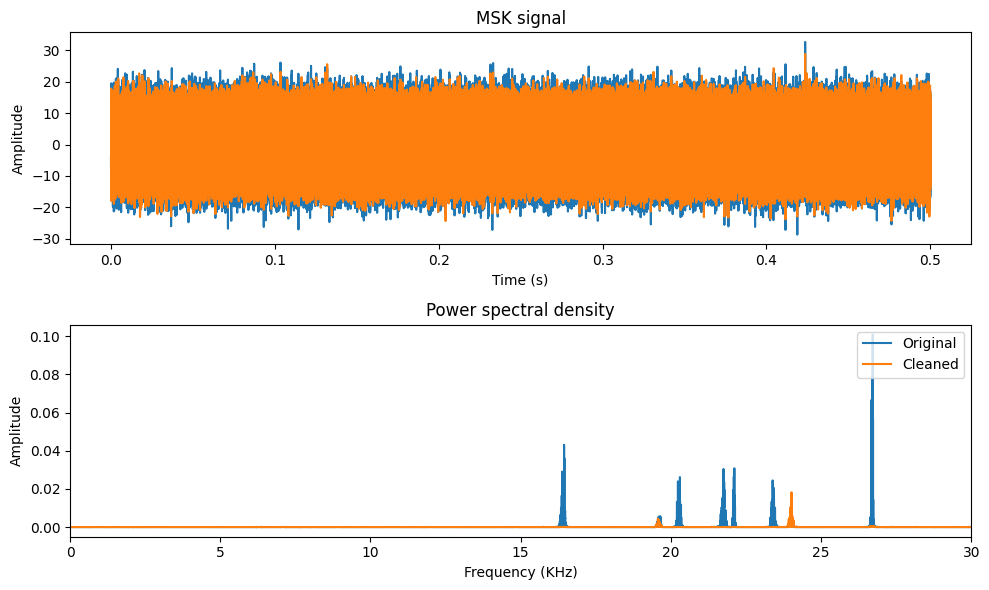

In [98]:
# calculate fft
f, fft_msk_clean = signal.periodogram(msk_clean, fs, nfft=len(msk_clean))

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

axs[0].plot(t, msk_data, label='Original')
axs[0].plot(t, msk_clean, label='Cleaned')
axs[0].set_ylabel('Amplitude')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('MSK signal')

#axs[1].plot(f/1e3, fft_msk_clean, label='Cleaned')#10*np.log10(Pxx))
axs[1].plot(f/1e3, (fft_msk_data), label='Original')#10*np.log10(Pxx))
axs[1].plot(f/1e3, (fft_msk_clean), label='Cleaned')#10*np.log10(Pxx))
axs[1].set_ylabel('Amplitude')
axs[1].set_xlabel('Frequency (KHz)')
axs[1].set_title('Power spectral density')
axs[1].set_xlim(0, 30)
#axs[1].set_ylim(-100, 0)
plt.legend(loc='upper right')
plt.tight_layout()

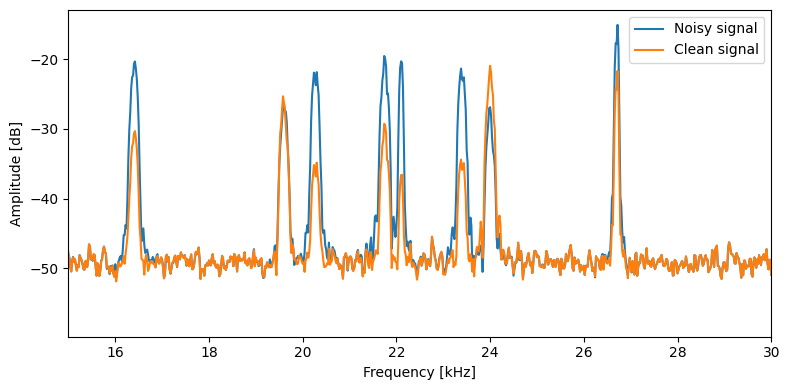

In [102]:
f, pxx_noise = signal.welch(msk_data, fs, nperseg=len(msk_data)/10) 
f, pxx_clean = signal.welch(msk_clean, fs, nperseg=len(msk_clean)/10)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(f/1e3, 10*np.log10(pxx_noise), label='Noisy signal')
ax.plot(f/1e3, 10*np.log10(pxx_clean), label='Clean signal')


ax.set_ylabel('Amplitude [dB]')
ax.set_xlabel('Frequency [kHz]')
ax.set_xlim(15, 30)
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig('figures/analysis/Cleaned_signal_zeroes.pdf')

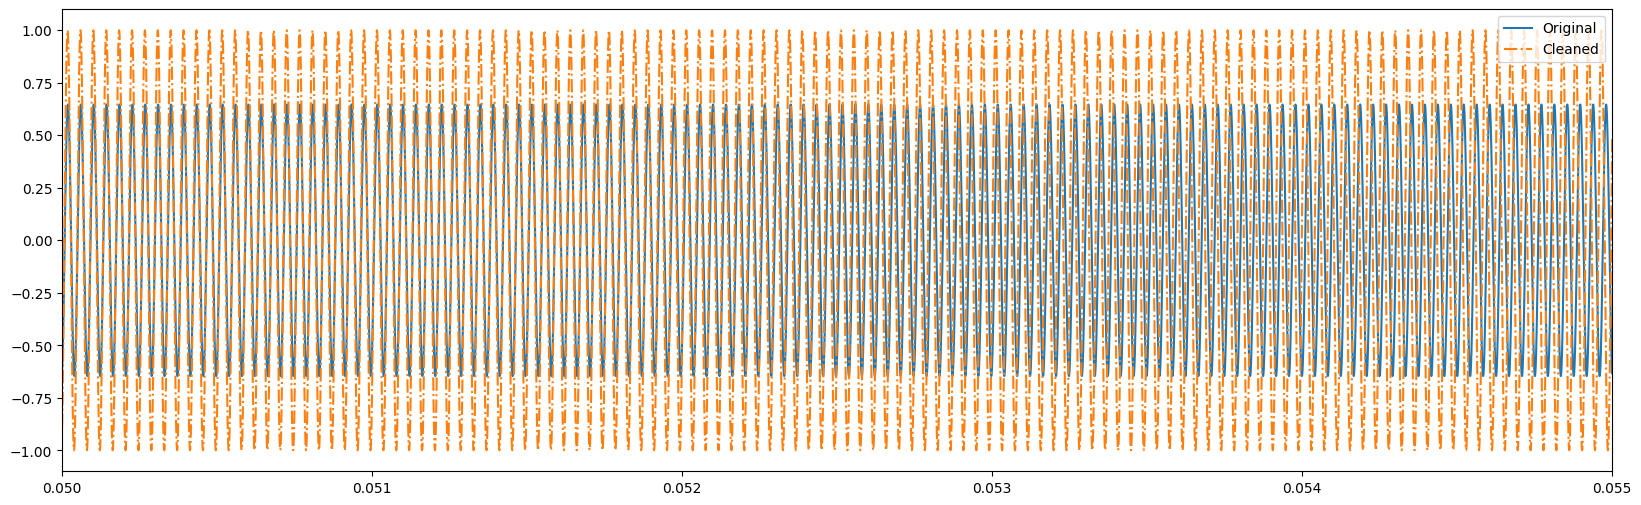

In [91]:
i_test = 6
s_test, t, _ = generate_msk_data(decoded_bits[i_test,0:int(time/T_symbols[i_test])], T_symbols[i_test], carriers[i_test], fs, offset=tau_hat[i_test], phase_offset=theta_hat[i_test], amplitude=a_hat[i_test])
#s_test, t, _ = generate_msk_data(decoded_bits[i_test,0:int(time/T_symbols[i_test])], T_symbols[i_test], carriers[i_test], fs, offset=offset[i_test], phase_offset=phase_offset[i_test])
plt.figure(figsize=(20, 6))
plt.plot(t, msk_data_single[i_test], label='Original')
plt.plot(t, s_test, ls='-.', label='Cleaned')
plt.xlim(1/200*10, 11*1/200)
plt.legend(loc='upper right')